In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.options.display.max_rows = 500

In [2]:
data0 = pd.read_csv('Data/3/prices_round_3_day_0.csv', sep = ';', header = 0)
data1 = pd.read_csv('Data/3/prices_round_3_day_1.csv', sep = ';', header = 0)
data2 = pd.read_csv('Data/3/prices_round_3_day_2.csv', sep = ';', header = 0)

data0

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,0,0,VOLCANIC_ROCK_VOUCHER_10500,99.0,19.0,NaN,NaN,NaN,NaN,100,19,NaN,NaN,NaN,NaN,99.5,0.0
1,0,0,DJEMBES,13493.0,72.0,NaN,NaN,NaN,NaN,13494,72,NaN,NaN,NaN,NaN,13493.5,0.0
2,0,0,CROISSANTS,4321.0,111.0,NaN,NaN,NaN,NaN,4322,111,NaN,NaN,NaN,NaN,4321.5,0.0
3,0,0,JAMS,6631.0,210.0,NaN,NaN,NaN,NaN,6633,210,NaN,NaN,NaN,NaN,6632.0,0.0
4,0,0,VOLCANIC_ROCK_VOUCHER_10000,505.0,19.0,NaN,NaN,NaN,NaN,506,19,NaN,NaN,NaN,NaN,505.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139995,0,999900,VOLCANIC_ROCK_VOUCHER_10250,277.0,7.0,NaN,NaN,NaN,NaN,278,18,NaN,NaN,NaN,NaN,277.5,0.0
139996,0,999900,JAMS,6541.0,183.0,NaN,NaN,NaN,NaN,6543,183,NaN,NaN,NaN,NaN,6542.0,0.0
139997,0,999900,VOLCANIC_ROCK_VOUCHER_10000,515.0,7.0,NaN,NaN,NaN,NaN,517,18,NaN,NaN,NaN,NaN,516.0,0.0
139998,0,999900,DJEMBES,13409.0,64.0,NaN,NaN,NaN,NaN,13410,64,NaN,NaN,NaN,NaN,13409.5,0.0


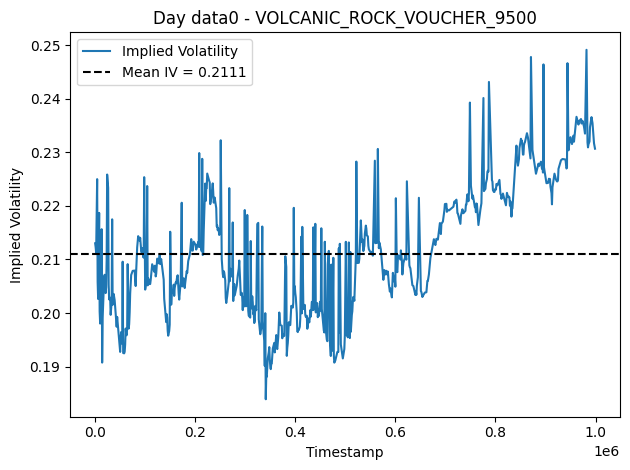

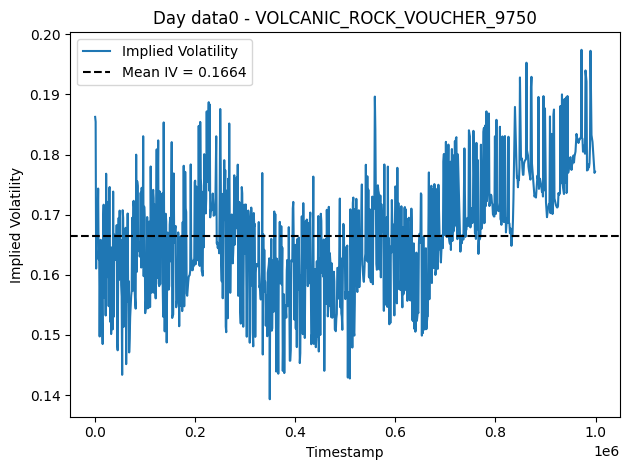

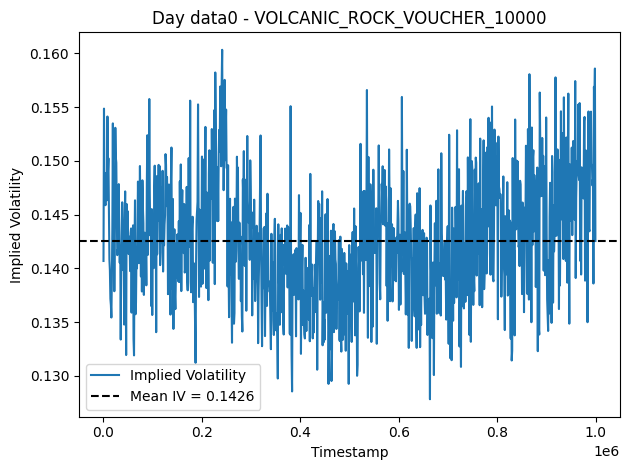

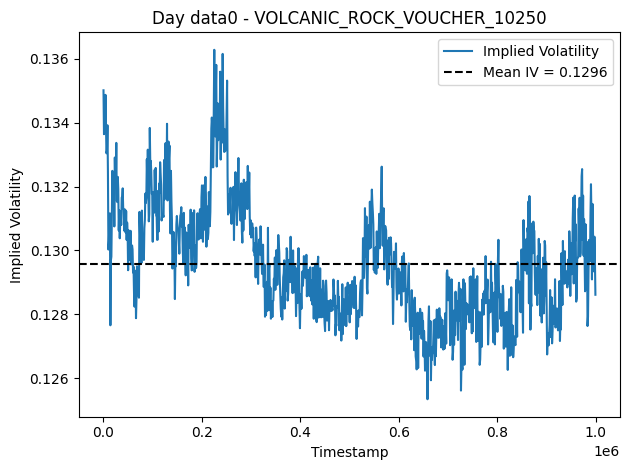

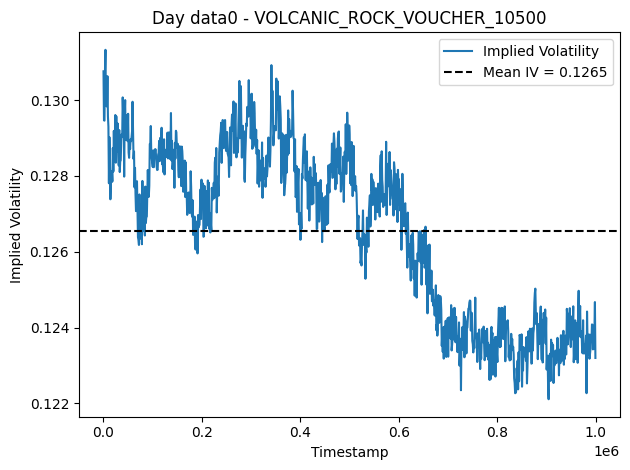

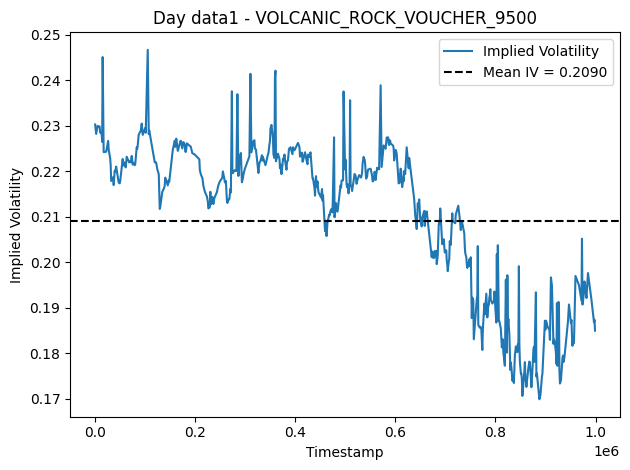

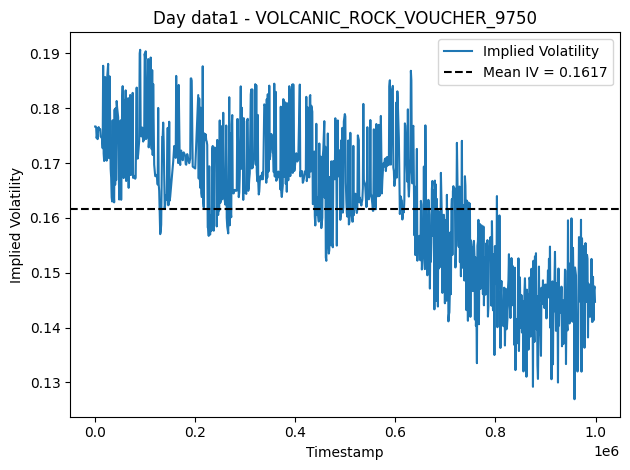

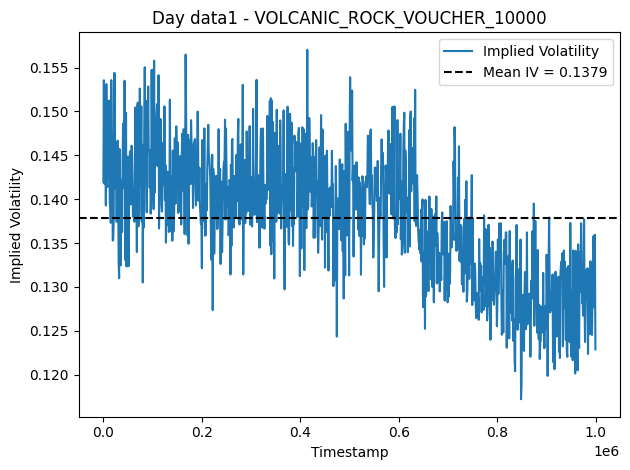

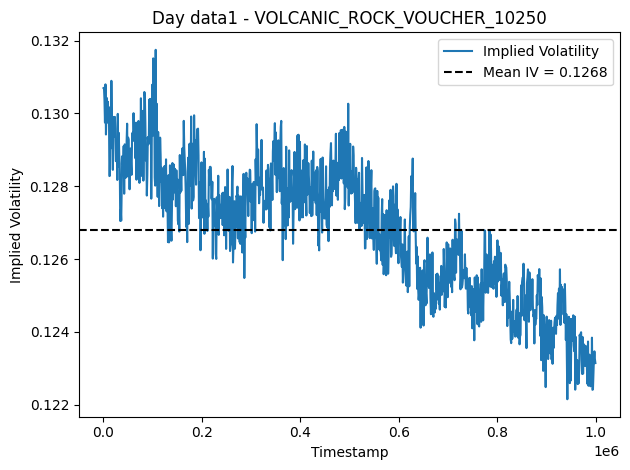

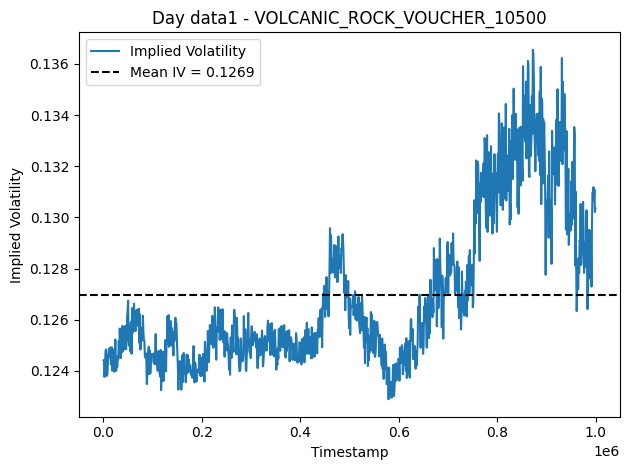

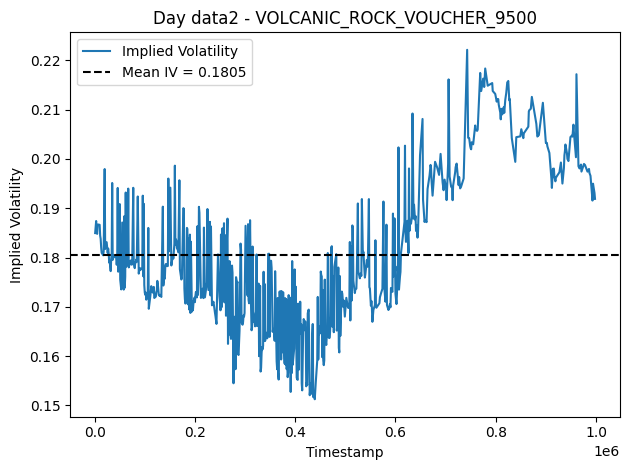

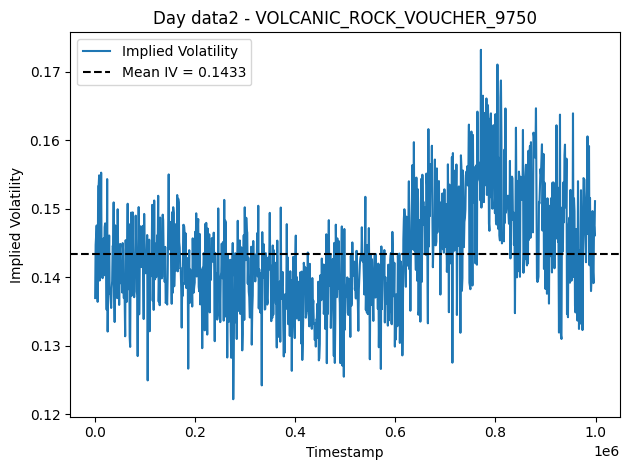

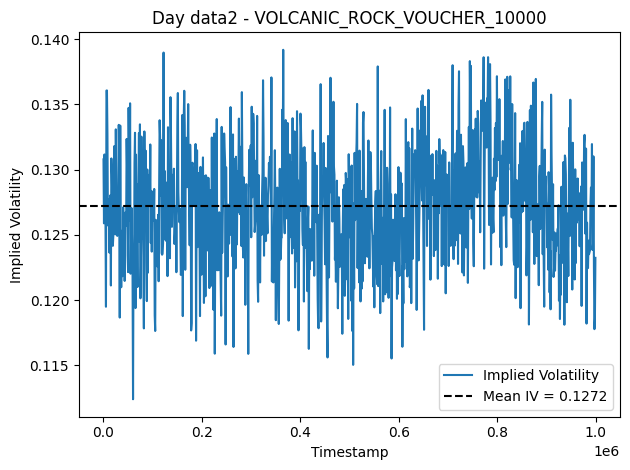

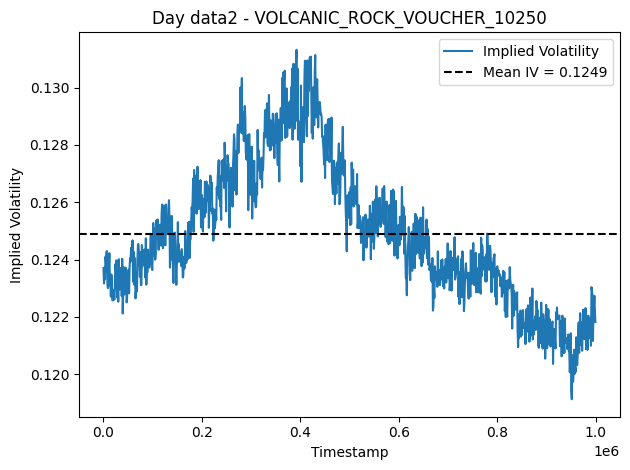

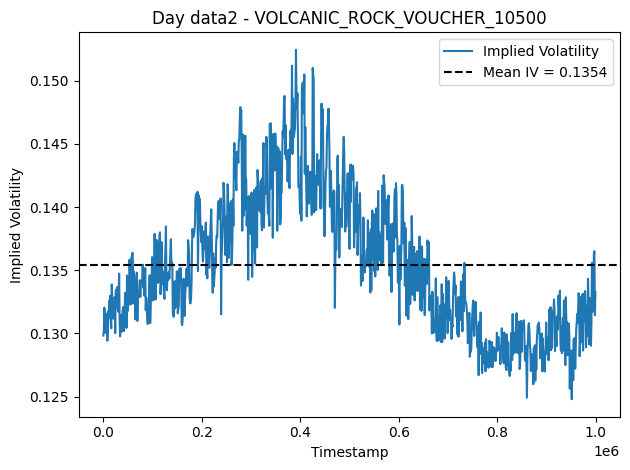

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

# Black-Scholes call price function for a European call.
def bs_call(S, K, T, sigma):
    if T <= 0:
        return max(S - K, 0)
    d1 = (np.log(S / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * norm.cdf(d2)

# Function to compute implied volatility given the observed call price.
def implied_volatility_call(C_observed, S, K, T, tol=1e-8):
    """
    If the observed call price is almost exactly equal to its intrinsic value,
    the extrinsic value is negligible and the implied vol is not meaningful.
    In that case, we return np.nan.
    """
    intrinsic = max(S - K, 0)
    if C_observed <= intrinsic + tol:
        return np.nan

    def objective(sigma):
        return bs_call(S, K, T, sigma) - C_observed

    try:
        iv = brentq(objective, 1e-6, 5)
    except Exception:
        iv = np.nan
    # If the computed IV is extremely low (near zero), we treat it as invalid.
    if iv < 1e-4:
        return np.nan
    return iv

# Compute time-to-expiry by linear interpolation.
# The timestamp goes from 0 to 999900, scaling over 1,000,000.
def compute_time_to_expiry(timestamp, T_initial, T_final):
    return T_initial - ((T_initial - T_final) / 1_000_000) * timestamp

# Process one day's dataframe: compute implied volatilities and generate plots.
def process_dataframe(df, T_initial, T_final, day_label):
    # Pivot the dataframe so that each product is a column and the index is the timestamp.
    df_pivot = df.pivot(index='timestamp', columns='product', values='mid_price')
    
    # Downsample to every 10th timestamp (1/10 downsampling).
    df_sub = df_pivot.iloc[::10]
    
    # Define the voucher products and the underlying.
    vouchers = [
        "VOLCANIC_ROCK_VOUCHER_9500", 
        "VOLCANIC_ROCK_VOUCHER_9750", 
        "VOLCANIC_ROCK_VOUCHER_10000",
        "VOLCANIC_ROCK_VOUCHER_10250", 
        "VOLCANIC_ROCK_VOUCHER_10500"
    ]
    underlying_label = "VOLCANIC_ROCK"
    
    # For each voucher, compute the implied volatility time series.
    for voucher in vouchers:
        try:
            K = float(voucher.split('_')[-1])
        except Exception as e:
            print(f"Error parsing strike for {voucher}: {e}")
            continue
        
        if underlying_label not in df_sub.columns or voucher not in df_sub.columns:
            print(f"Data missing for {voucher} or underlying {underlying_label}. Skipping.")
            continue
        
        valid_timestamps = []
        iv_values = []
        # Loop over each sampled timestamp.
        for t in df_sub.index.values:
            S = df_sub.loc[t, underlying_label]
            voucher_price = df_sub.loc[t, voucher]
            T = compute_time_to_expiry(t, T_initial, T_final)
            # Check for missing or invalid data.
            if pd.isnull(S) or pd.isnull(voucher_price) or S <= 0 or T <= 0:
                continue
            
            iv = implied_volatility_call(voucher_price, S, K, T)
            # Skip points where iv returns NaN (including effectively 0 values).
            if np.isnan(iv):
                continue
                
            valid_timestamps.append(t)
            iv_values.append(iv)
        
        valid_timestamps = np.array(valid_timestamps)
        iv_values = np.array(iv_values)
        
        # Create the time series plot for this voucher.
        plt.figure()
        plt.plot(valid_timestamps, iv_values, label='Implied Volatility')
        if len(iv_values) > 0:
            mean_iv = np.nanmean(iv_values)
            plt.axhline(y=mean_iv, linestyle='--', color='black', label=f'Mean IV = {mean_iv:.4f}')
        plt.xlabel('Timestamp')
        plt.ylabel('Implied Volatility')
        plt.title(f'Day {day_label} - {voucher}')
        plt.legend()
        plt.tight_layout()
        plt.show()

# Main routine: Process each day's dataframe.
def main():
    # For data0, T decreases linearly from 8/250 to 7/250 over timestamps 0 to 1,000,000.
    process_dataframe(data0, T_initial=8/250, T_final=7/250, day_label="data0")
    # For data1, T decreases linearly from 7/250 to 6/250.
    process_dataframe(data1, T_initial=7/250, T_final=6/250, day_label="data1")
    # For data2, T decreases linearly from 6/250 to 5/250.
    process_dataframe(data2, T_initial=6/250, T_final=5/250, day_label="data2")
    
if __name__ == "__main__":
    main()


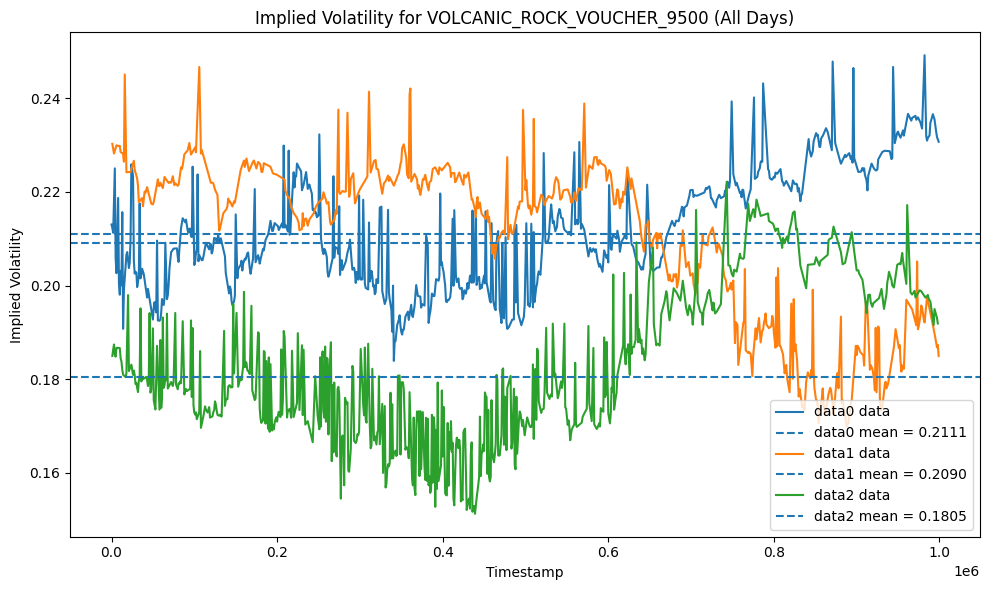

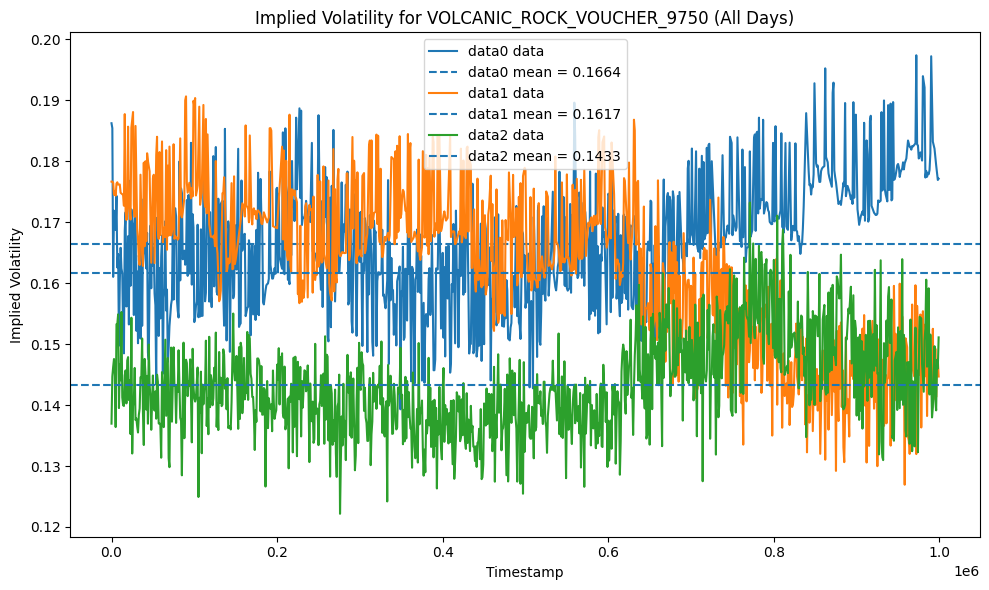

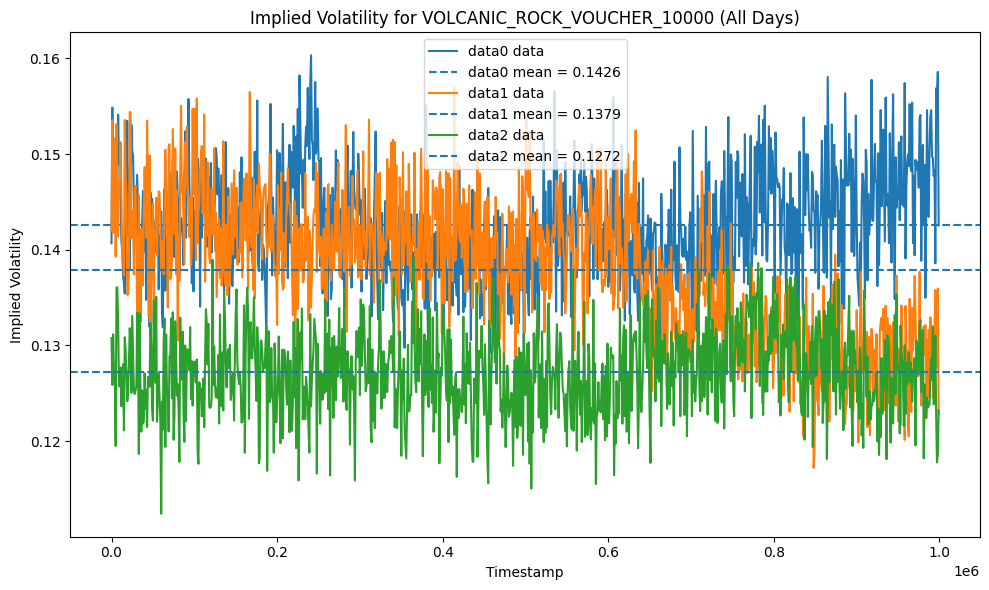

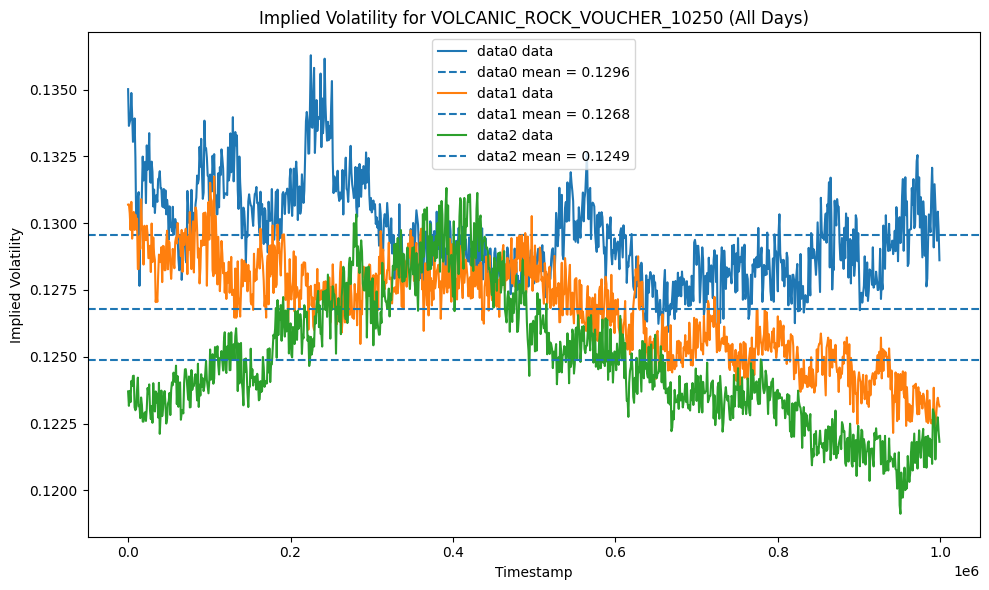

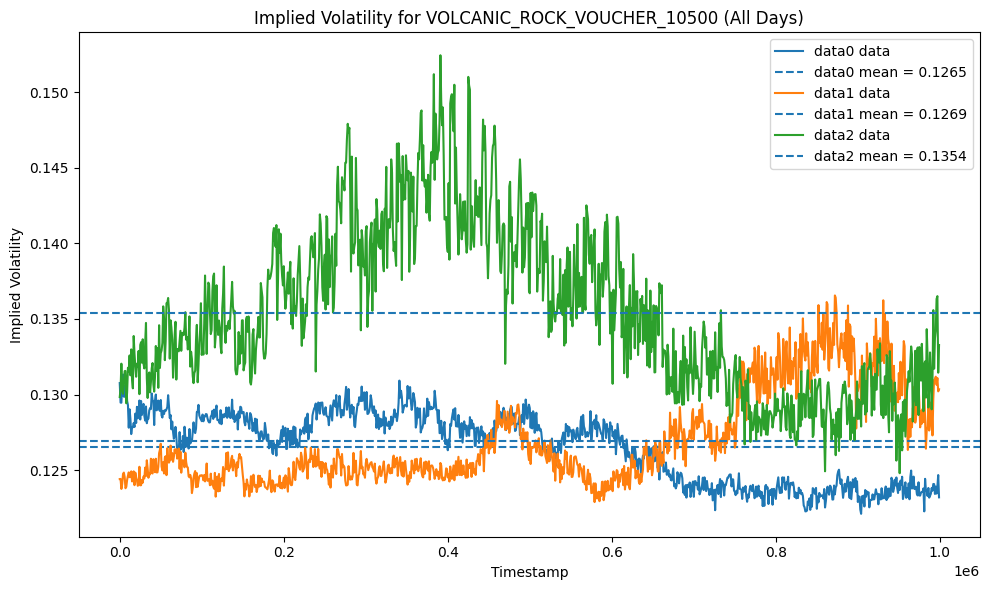

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

# Black-Scholes call price function for a European call
def bs_call(S, K, T, sigma):
    if T <= 0:
        return max(S - K, 0)
    d1 = (np.log(S / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * norm.cdf(d2)

# Compute implied volatility given the observed call price.
# If the observed price is too close to intrinsic value, return NaN.
def implied_volatility_call(C_observed, S, K, T, tol=1e-8):
    intrinsic = max(S - K, 0)
    if C_observed <= intrinsic + tol:
        return np.nan

    def objective(sigma):
        return bs_call(S, K, T, sigma) - C_observed

    try:
        iv = brentq(objective, 1e-6, 5)
    except Exception:
        iv = np.nan
    # If the computed IV is extremely low (near zero), treat it as invalid.
    if iv < 1e-4:
        return np.nan
    return iv

# Compute time-to-expiry via linear interpolation.
# T_initial and T_final are defined per day and timestamp runs from 0 to 1,000,000.
def compute_time_to_expiry(timestamp, T_initial, T_final):
    return T_initial - ((T_initial - T_final) / 1_000_000) * timestamp

# For each voucher, process each day's data, compute the IV time series, and plot on one figure.
def process_by_voucher(data_days):
    # data_days is a dictionary where key = day label, and value = (dataframe, T_initial, T_final)
    vouchers = [
        "VOLCANIC_ROCK_VOUCHER_9500", 
        "VOLCANIC_ROCK_VOUCHER_9750", 
        "VOLCANIC_ROCK_VOUCHER_10000",
        "VOLCANIC_ROCK_VOUCHER_10250", 
        "VOLCANIC_ROCK_VOUCHER_10500"
    ]
    underlying_label = "VOLCANIC_ROCK"
    
    # Loop over each voucher product.
    for voucher in vouchers:
        try:
            K = float(voucher.split('_')[-1])
        except Exception as e:
            print(f"Error parsing strike for {voucher}: {e}")
            continue

        plt.figure(figsize=(10, 6))
        
        # For each day, calculate the IV time series.
        for day_label, (df, T_initial, T_final) in data_days.items():
            # Pivot the dataframe so that index=timestamps and columns=products.
            df_pivot = df.pivot(index='timestamp', columns='product', values='mid_price')
            # Downsample: every 10th timestamp.
            df_sub = df_pivot.iloc[::10]
            
            # Check that both underlying and voucher data exist.
            if underlying_label not in df_sub.columns or voucher not in df_sub.columns:
                print(f"Data missing for {voucher} or underlying {underlying_label} in {day_label}. Skipping day.")
                continue
            
            valid_timestamps = []
            iv_values = []
            # Loop over each sampled timestamp.
            for t in df_sub.index.values:
                S = df_sub.loc[t, underlying_label]
                voucher_price = df_sub.loc[t, voucher]
                T = compute_time_to_expiry(t, T_initial, T_final)
                if pd.isnull(S) or pd.isnull(voucher_price) or S <= 0 or T <= 0:
                    continue
                iv = implied_volatility_call(voucher_price, S, K, T)
                # Skip the point if iv is NaN (including effectively zero values).
                if np.isnan(iv):
                    continue
                valid_timestamps.append(t)
                iv_values.append(iv)
            
            valid_timestamps = np.array(valid_timestamps)
            iv_values = np.array(iv_values)
            
            # Plot this day's IV time series if there are valid points.
            if len(iv_values) > 0:
                plt.plot(valid_timestamps, iv_values, label=f"{day_label} data")
                mean_iv = np.nanmean(iv_values)
                plt.axhline(y=mean_iv, linestyle='--', label=f"{day_label} mean = {mean_iv:.4f}")
            else:
                print(f"No valid IV data for {voucher} on {day_label}.")
        
        plt.xlabel('Timestamp')
        plt.ylabel('Implied Volatility')
        plt.title(f"Implied Volatility for {voucher} (All Days)")
        plt.legend()
        plt.tight_layout()
        plt.show()

# Main routine: Prepare the data for each day and call the grouped plotting function.
def main():
    # Prepare dictionary mapping day labels to (dataframe, T_initial, T_final)
    # Note: The timestamps in each dataframe run from 0 to 999900.
    data_days = {
        "data0": (data0, 8/250, 7/250),
        "data1": (data1, 7/250, 6/250),
        "data2": (data2, 6/250, 5/250)
    }
    process_by_voucher(data_days)

if __name__ == "__main__":
    main()


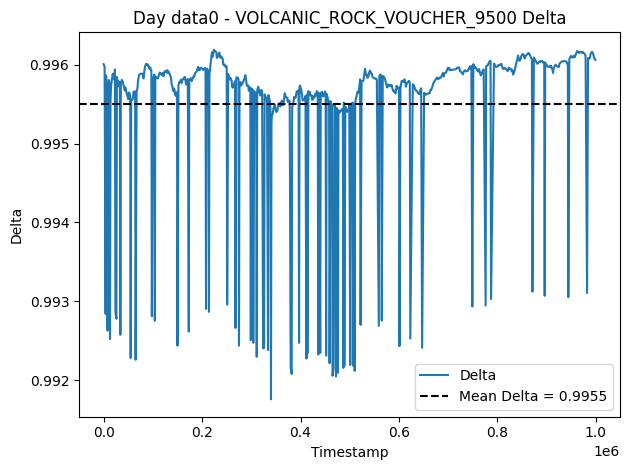

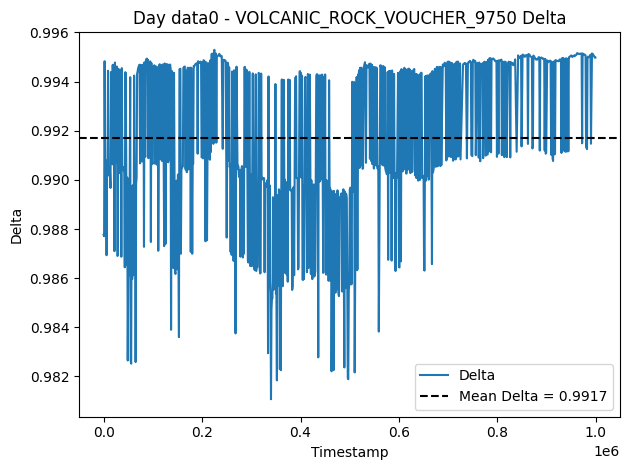

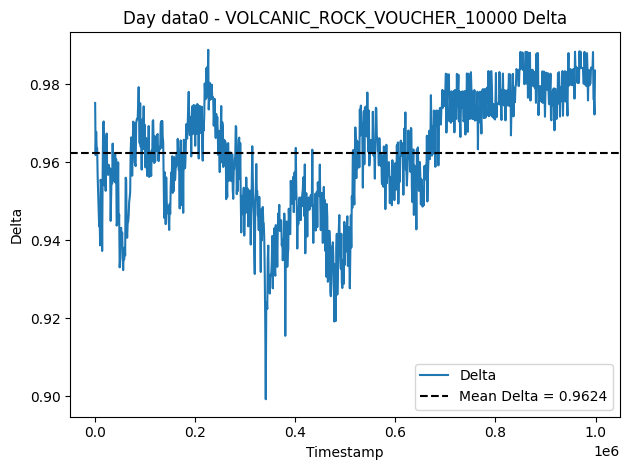

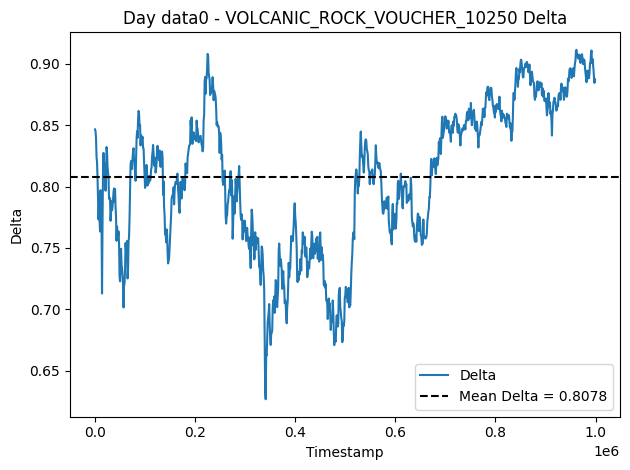

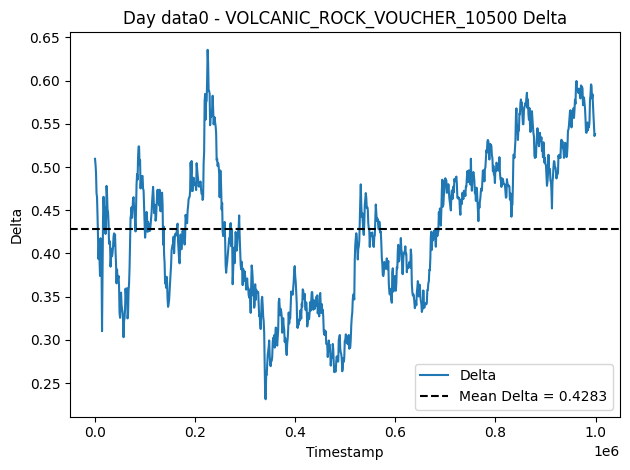

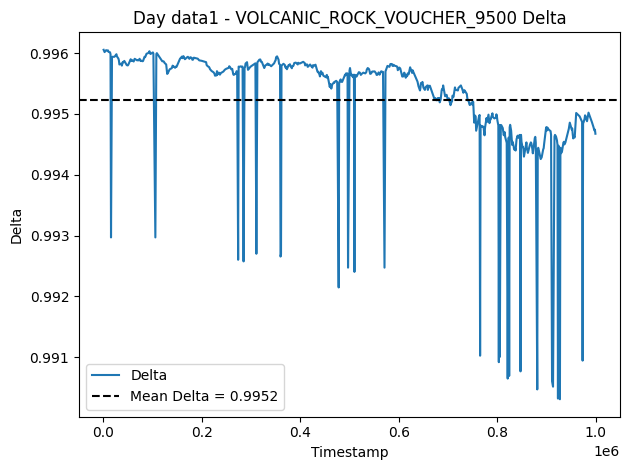

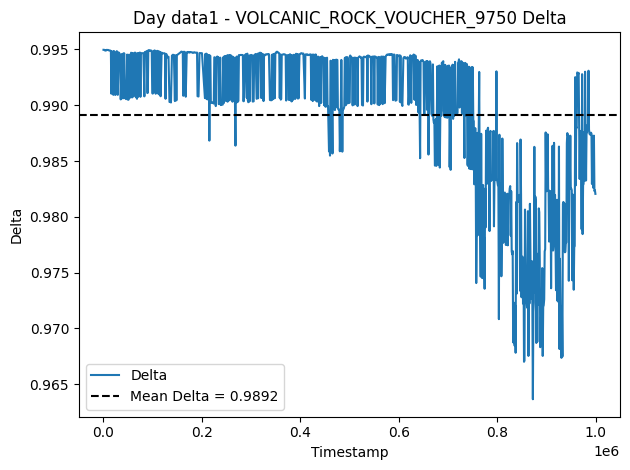

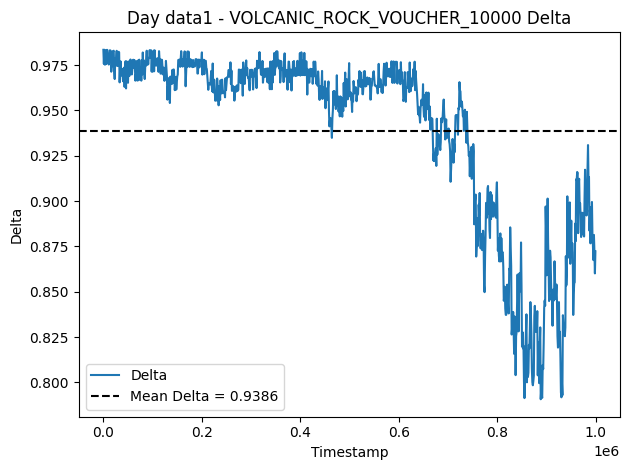

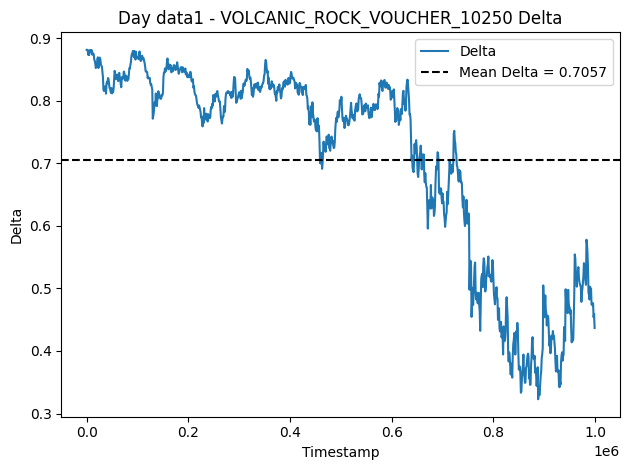

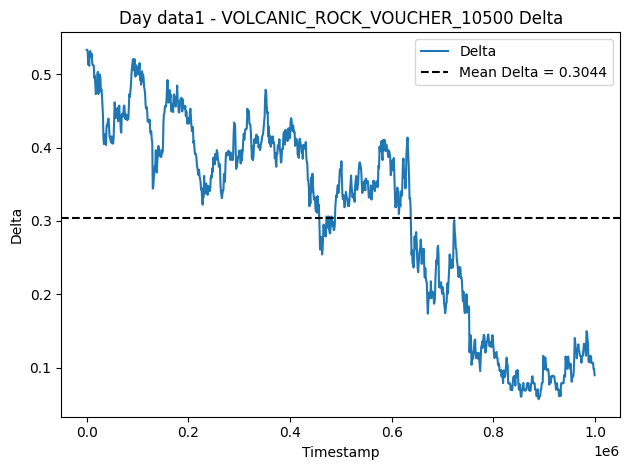

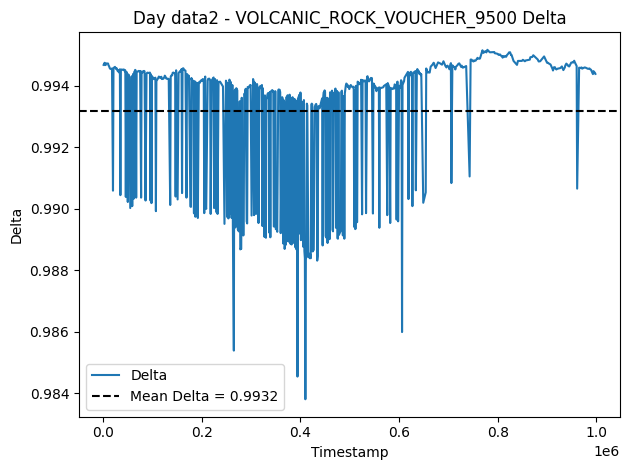

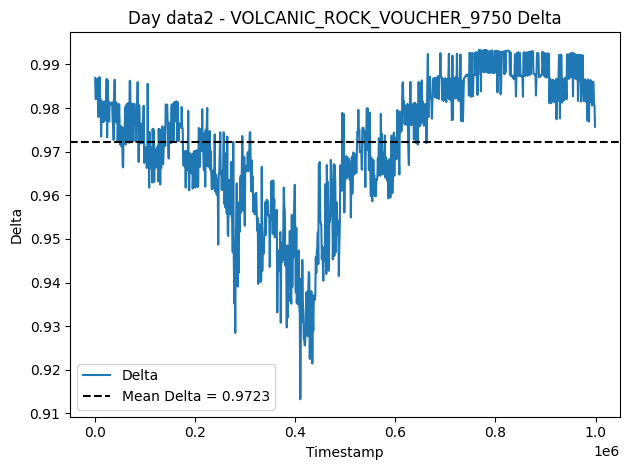

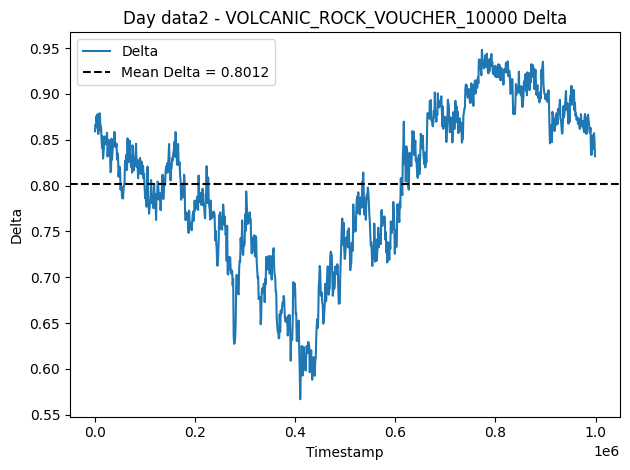

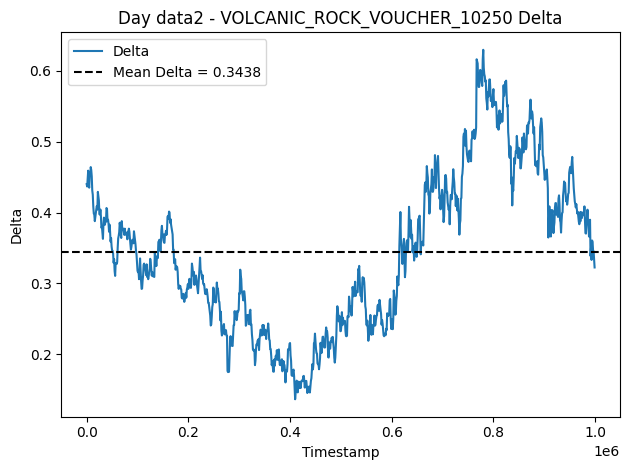

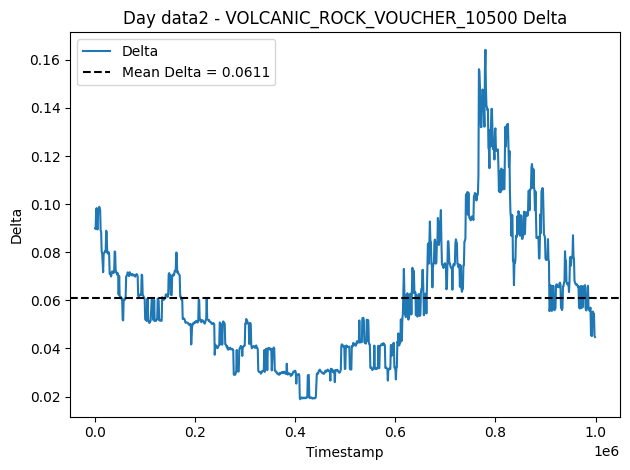

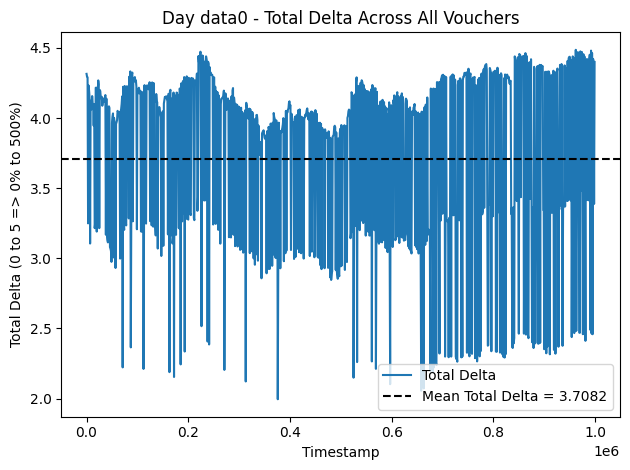

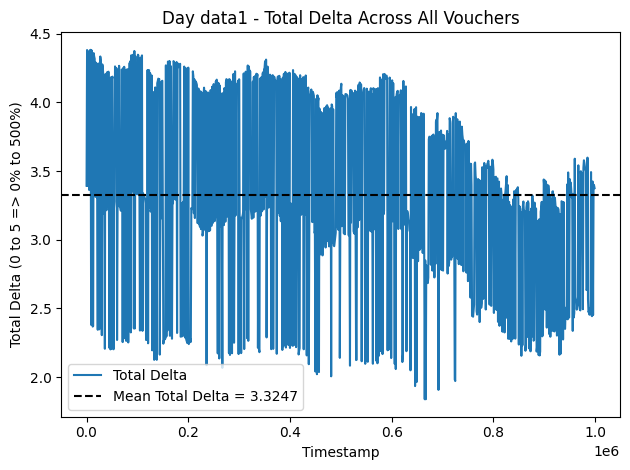

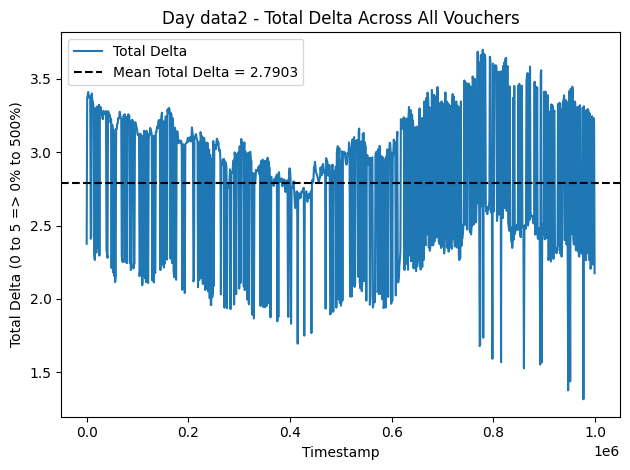

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

# -------------------------
# Black–Scholes Functions
# -------------------------

def bs_call(S, K, T, sigma):
    """ Standard Black–Scholes call option pricing. """
    if T <= 0:
        # If time is zero or negative, payoff is max(S-K, 0).
        return max(S - K, 0)
    d1 = (np.log(S/K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * norm.cdf(d2)

def bs_delta(S, K, T, sigma):
    """ Delta for a European call under Black–Scholes. """
    if T <= 0:
        # Instant expiry => delta is 1 if S>K, else 0
        return 1.0 if S > K else 0.0
    d1 = (np.log(S/K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

def implied_volatility_call(C_observed, S, K, T):
    """
    Invert the Black–Scholes formula to find implied volatility.
    Includes additional checks to skip outlier or invalid data.
    """

    # Intrinsic value check
    intrinsic = max(S - K, 0)
    # If call price is not at least slightly above intrinsic, skip
    if C_observed < intrinsic + 1e-4:
        return np.nan
    
    # If the call price exceeds the underlying by more than a small margin, skip
    # (No-dividend call should cost ≤ S in typical BS assumptions)
    if C_observed > S + 1e-4:
        return np.nan

    # Root-finding objective
    def objective(sigma):
        return bs_call(S, K, T, sigma) - C_observed
    
    # Attempt Brent's method within a reasonable range for implied vol
    try:
        iv = brentq(objective, 1e-6, 5)
    except Exception:
        return np.nan
    
    # If the computed IV is extremely low or we have another numerical quirk, skip
    if iv < 1e-5:
        return np.nan
    
    # Final consistency check: ensure the BS price at this iv is close to the observed call price
    c_check = bs_call(S, K, T, iv)
    # If the difference is large, we treat it as an unreliable solution
    if abs(c_check - C_observed) > 0.5:  # Adjust threshold as needed
        return np.nan
    
    return iv

# -------------------------
# Time-to-Expiry Calculation
# -------------------------

def compute_time_to_expiry(timestamp, T_initial, T_final):
    """
    Linear interpolation of T as timestamp goes from 0 to 1,000,000.
    e.g., data0: T goes from 8/250 to 7/250 over that range.
    """
    return T_initial - ((T_initial - T_final) / 1_000_000) * timestamp

# -------------------------
# Part 1: Individual Voucher Delta (15 Charts)
# -------------------------

def process_dataframe_for_delta(df, T_initial, T_final, day_label):
    # Pivot & downsample
    df_pivot = df.pivot(index='timestamp', columns='product', values='mid_price')
    df_sub = df_pivot.iloc[::10]  # keep every 10th row
    
    vouchers = [
        "VOLCANIC_ROCK_VOUCHER_9500", 
        "VOLCANIC_ROCK_VOUCHER_9750", 
        "VOLCANIC_ROCK_VOUCHER_10000",
        "VOLCANIC_ROCK_VOUCHER_10250", 
        "VOLCANIC_ROCK_VOUCHER_10500"
    ]
    underlying_label = "VOLCANIC_ROCK"
    
    for voucher in vouchers:
        try:
            K = float(voucher.split('_')[-1])
        except Exception as e:
            print(f"Error parsing strike from {voucher}: {e}")
            continue
        
        if underlying_label not in df_sub.columns or voucher not in df_sub.columns:
            print(f"Data missing for {voucher} or underlying {underlying_label} in {day_label}. Skipping.")
            continue
        
        valid_timestamps = []
        delta_values = []
        
        for t in df_sub.index.values:
            S = df_sub.loc[t, underlying_label]
            voucher_price = df_sub.loc[t, voucher]
            T = compute_time_to_expiry(t, T_initial, T_final)
            
            # Basic data checks
            if pd.isnull(S) or pd.isnull(voucher_price) or S <= 0 or T <= 0:
                continue
            
            # Compute implied volatility
            iv = implied_volatility_call(voucher_price, S, K, T)
            if np.isnan(iv):
                continue
            
            # Compute delta
            d = bs_delta(S, K, T, iv)
            # If for some reason d is outside [0, 1], skip
            if d < 0 or d > 1:
                continue
            
            valid_timestamps.append(t)
            delta_values.append(d)
        
        valid_timestamps = np.array(valid_timestamps)
        delta_values = np.array(delta_values)
        
        # Plot for this voucher/day
        plt.figure()
        plt.plot(valid_timestamps, delta_values, label='Delta')
        if len(delta_values) > 0:
            mean_delta = np.nanmean(delta_values)
            plt.axhline(y=mean_delta, linestyle='--', color='black', 
                        label=f"Mean Delta = {mean_delta:.4f}")
        plt.xlabel('Timestamp')
        plt.ylabel('Delta')
        plt.title(f"Day {day_label} - {voucher} Delta")
        plt.legend()
        plt.tight_layout()
        plt.show()

# -------------------------
# Part 2: Total Delta (3 Charts, One Per Day)
# -------------------------

def process_total_delta(df, T_initial, T_final, day_label):
    # Pivot & downsample
    df_pivot = df.pivot(index='timestamp', columns='product', values='mid_price')
    df_sub = df_pivot.iloc[::10]
    
    vouchers = [
        "VOLCANIC_ROCK_VOUCHER_9500", 
        "VOLCANIC_ROCK_VOUCHER_9750", 
        "VOLCANIC_ROCK_VOUCHER_10000",
        "VOLCANIC_ROCK_VOUCHER_10250", 
        "VOLCANIC_ROCK_VOUCHER_10500"
    ]
    underlying_label = "VOLCANIC_ROCK"
    
    total_delta_map = {}  # { timestamp: sum_of_deltas_across_vouchers }
    
    for t in df_sub.index.values:
        S = df_sub.loc[t, underlying_label]
        T = compute_time_to_expiry(t, T_initial, T_final)
        if pd.isnull(S) or S <= 0 or T <= 0:
            continue
        
        sum_delta = 0.0
        
        for voucher in vouchers:
            if voucher not in df_sub.columns:
                continue
            voucher_price = df_sub.loc[t, voucher]
            if pd.isnull(voucher_price):
                # Missing data => treat delta as 0
                continue
            
            # Implied vol
            try:
                K = float(voucher.split('_')[-1])
            except Exception:
                continue
            iv = implied_volatility_call(voucher_price, S, K, T)
            if np.isnan(iv):
                continue
            
            # Delta
            d = bs_delta(S, K, T, iv)
            if d < 0 or d > 1:
                # Out-of-bounds => skip
                continue
            sum_delta += d
        
        total_delta_map[t] = sum_delta
    
    if not total_delta_map:
        print(f"No valid total delta data for {day_label}.")
        return
    
    # Sort timestamps for plotting
    timestamps = np.array(sorted(total_delta_map.keys()))
    total_delta_vals = np.array([total_delta_map[ts] for ts in timestamps])
    
    plt.figure()
    plt.plot(timestamps, total_delta_vals, label='Total Delta')
    if len(total_delta_vals) > 0:
        mean_total = np.nanmean(total_delta_vals)
        plt.axhline(y=mean_total, linestyle='--', color='black', 
                    label=f"Mean Total Delta = {mean_total:.4f}")
    plt.xlabel('Timestamp')
    plt.ylabel('Total Delta (0 to 5 => 0% to 500%)')
    plt.title(f"Day {day_label} - Total Delta Across All Vouchers")
    plt.legend()
    plt.tight_layout()
    plt.show()

# -------------------------
# Main
# -------------------------

def main():
    # Map each day's data to its T-initial and T-final
    data_days = {
        "data0": (data0, 8/250, 7/250),
        "data1": (data1, 7/250, 6/250),
        "data2": (data2, 6/250, 5/250)
    }
    
    # (1) 15 Charts: 5 vouchers × 3 days
    for day_label, (df, T_initial, T_final) in data_days.items():
        process_dataframe_for_delta(df, T_initial, T_final, day_label)
    
    # (2) 3 Charts: total delta for each day
    for day_label, (df, T_initial, T_final) in data_days.items():
        process_total_delta(df, T_initial, T_final, day_label)

if __name__ == "__main__":
    main()
